## Exercise 1: Logistic Regression on a Toy 2D Dataset

1. Generate two Gaussian clusters in $\mathbb{R}^2$ and associate them with a class depending on which cluster each point lies on, e.g.:
   - Class 0 centered at $(-2, -2)$ with variance $1$,
   - Class 1 centered at $(2, 2)$ with variance $0.5$.



In [19]:
import numpy as np
import matplotlib.pyplot as plt

n0 = 200
n1 = 200

mu0 = np.array([-2, -2])
mu1 = np.array([2, 2])

sigma0 = 1 * np.eye(2)
sigma1 = 0.5 * np.eye(2)

X0 = np.random.multivariate_normal(mu0, sigma0, n0)
X1 = np.random.multivariate_normal(mu1, sigma1, n1)

y0 = np.zeros(n0)
y1 = np.ones(n1)

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])

N = X.shape[0]

2. Plot the dataset in 2D using `plt.scatter` so that each cluster is colored according to its class.

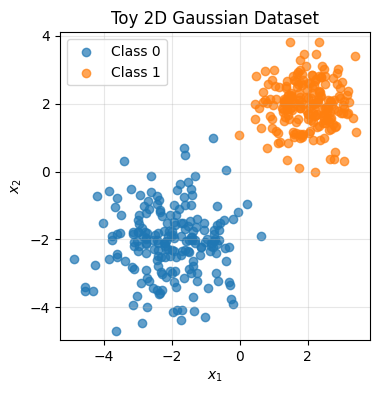

In [20]:
plt.figure(figsize=(4, 4))

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color="tab:blue", alpha=0.7, label="Class 0")

plt.scatter(X[y == 1, 0], X[y == 1, 1],
            color="tab:orange", alpha=0.7, label="Class 1")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Toy 2D Gaussian Dataset")
plt.legend()
plt.grid(alpha=0.3)
plt.axis("equal")

plt.show()


3. Implement logistic regression **from scratch** as did during class:
   
   $$
   f_\Theta(x) = \sigma(\Theta^T x),
   \qquad 
   \ell(\Theta; x,y)= -\big[y\log f_\Theta(x) + (1-y)\log(1 - f_\Theta(x))\big].
   $$

In [21]:
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def f(Theta, X):
    return sigmoid(X @ Theta)

def l(Theta, X, Y):
    Y_hat = f(Theta, X)
    eps = 1e-12
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def grad_l(Theta, X, Y):
    N = X.shape[0]
    Y_hat = f(Theta, X)
    return (X.T @ (Y_hat - Y)) / N


4. Train it using simple Gradient Descent on the full dataset. **Note:** the computation of $\nabla \mathcal{L}(\Theta; X, Y)$ for this choice of $\ell$ is given in the teaching note.


In [22]:
def GD(l, grad_l, Theta0, X, Y, eta, maxit):
    Theta = Theta0.copy()
    Theta_vals = [Theta.copy()]
    losses = [l(Theta, X, Y)]

    for k in range(maxit):
        Theta = Theta - eta * grad_l(Theta, X, Y)
        Theta_vals.append(Theta.copy())
        losses.append(l(Theta, X, Y))

    return Theta, np.array(Theta_vals), np.array(losses)

X_aug = np.hstack([np.ones((X.shape[0], 1)), X])  
Y = y.reshape(-1, 1)                                

eta = 0.1
maxit = 1000
Theta0 = np.zeros((X_aug.shape[1], 1))              

Theta_star, Theta_hist, loss_hist = GD(
    l, grad_l,
    Theta0,
    X_aug, Y,
    eta=eta,
    maxit=maxit
)

/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: divide by zero encountered in matmul
  return sigmoid(X @ Theta)
/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: overflow encountered in matmul
  return sigmoid(X @ Theta)
/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: invalid value encountered in matmul
  return sigmoid(X @ Theta)



5. Visualize the learned **decision boundary**:
   - plot the line $\{\Theta^T x = 0\}$,
   - overlay with the dataset.


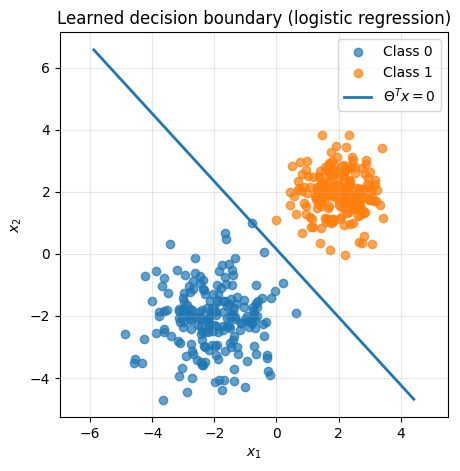

In [23]:
b, w1, w2 = Theta_star.ravel()

plt.figure(figsize=(5, 5))

plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.7, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.7, label="Class 1")

x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_line = np.linspace(x1_min, x1_max, 200)

if abs(w2) > 1e-12:
    x2_line = -(b + w1 * x1_line) / w2
    plt.plot(x1_line, x2_line, linewidth=2, label=r"$\Theta^T x = 0$")
else:
    x1_boundary = -b / w1
    plt.axvline(x1_boundary, linewidth=2, label=r"$\Theta^T x = 0$")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Learned decision boundary (logistic regression)")
plt.grid(alpha=0.3)
plt.axis("equal")
plt.legend()
plt.show()


6. Comment on why the decision boundary is linear.

## Exercise 2: SGD on Logistic Regression

Use the same synthetic dataset used in the previous exercise, but train logistic regression using **SGD** with the following choices:

1. Try different batch sizes:
   - $N_{\text{batch}} = 1$,
   - $N_{\text{batch}} = 10$,
   - $N_{\text{batch}} = N$ (full GD).

In [28]:
def accuracy(Theta, X, Y):
    p = f(Theta, X)
    y_pred = (p >= 0.5).astype(int)
    return np.mean(y_pred == Y)


def SGD(l, grad_l, X, Y, Theta0, lr=1e-2, batch_size=32, epochs=10):
    Theta = Theta0.copy()

    loss_hist = []
    acc_hist = []

    N = X.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(N)
        Xs, Ys = X[idx], Y[idx]

        for start in range(0, N, batch_size):
            Xb = Xs[start:start+batch_size]
            Yb = Ys[start:start+batch_size]

            g = grad_l(Theta, Xb, Yb)
            Theta = Theta - lr * g

        loss_hist.append(l(Theta, X, Y))
        acc_hist.append(accuracy(Theta, X, Y))

    return Theta, np.array(loss_hist), np.array(acc_hist)

X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
Y = y.reshape(-1, 1)

N = X_aug.shape[0]
batch_sizes = [1, 10, N]

lr = 0.1
epochs = 100
Theta0 = np.zeros((X_aug.shape[1], 1))

results = {}

for B in batch_sizes:
    Theta_star, loss_hist, acc_hist = SGD(
        l, grad_l,
        X_aug, Y,
        Theta0,
        lr=lr,
        batch_size=B,
        epochs=epochs
    )
    results[B] = {
        "Theta": Theta_star,
        "loss": loss_hist,
        "acc": acc_hist
    }
    print(f"B={B}: final loss={loss_hist[-1]:.4f}, final acc={acc_hist[-1]:.3f}")


/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: divide by zero encountered in matmul
  return sigmoid(X @ Theta)
/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: overflow encountered in matmul
  return sigmoid(X @ Theta)
/var/folders/x0/qnrsg5z55nl_0_1yffjdsv1c0000gn/T/ipykernel_2709/1995233795.py:6: RuntimeWarning: invalid value encountered in matmul
  return sigmoid(X @ Theta)


B=1: final loss=0.0008, final acc=1.000
B=10: final loss=0.0031, final acc=1.000
B=400: final loss=0.0270, final acc=0.998


2. For each setting:
   - Plot the loss vs epoch,
   - Plot the classification accuracy vs epoch.

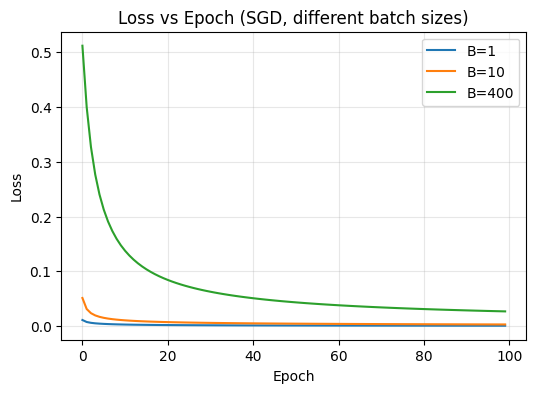

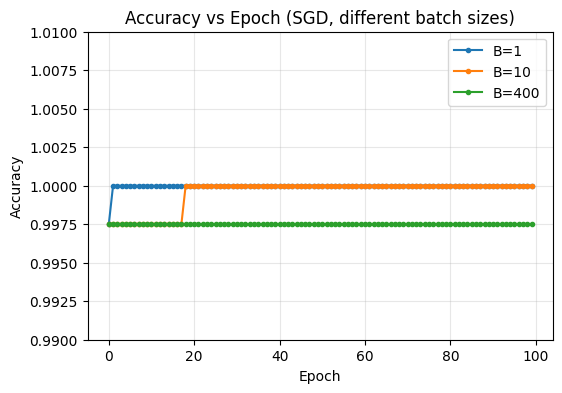

In [33]:
plt.figure(figsize=(6,4))
for B in batch_sizes:
    plt.plot(results[B]["loss"], label=f"B={B}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (SGD, different batch sizes)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
for B in batch_sizes:
    plt.plot(results[B]["acc"], marker="o", markersize=3, label=f"B={B}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (SGD, different batch sizes)")
plt.grid(alpha=0.3)
plt.legend()
plt.ylim(0.99, 1.01)   
plt.show()



3. Compare the stability and speed of convergence over the choice of different batch sizes.

4. Why the gradients become noisier for small batches? Why larger batches give smoother curves?